# Stroke Prediction - Binary Classification of Strokes Given Patient Characteristics

## 1. Initial data exploration and visualizations

In [117]:
import numpy as np
import pandas as pd
import mltools as ml

df1 = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
df2 = pd.read_csv("data/train.csv")
df = pd.concat([df1, df2])
print(df.head())

      id  gender   age  ...   bmi   smoking_status stroke
0   9046    Male  67.0  ...  36.6  formerly smoked      1
1  51676  Female  61.0  ...   NaN     never smoked      1
2  31112    Male  80.0  ...  32.5     never smoked      1
3  60182  Female  49.0  ...  34.4           smokes      1
4   1665  Female  79.0  ...  24.0     never smoked      1

[5 rows x 12 columns]


### Visualizing distribution of features

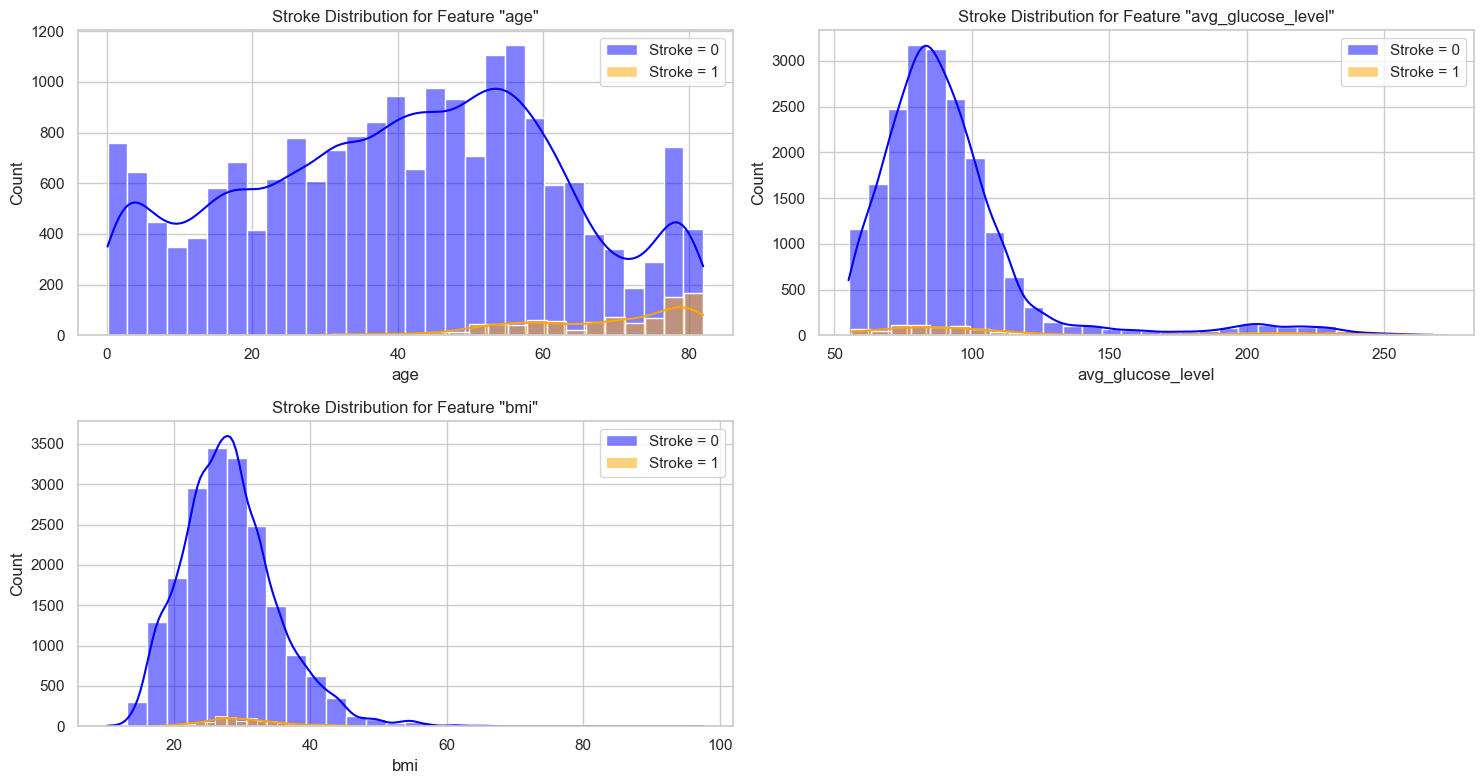

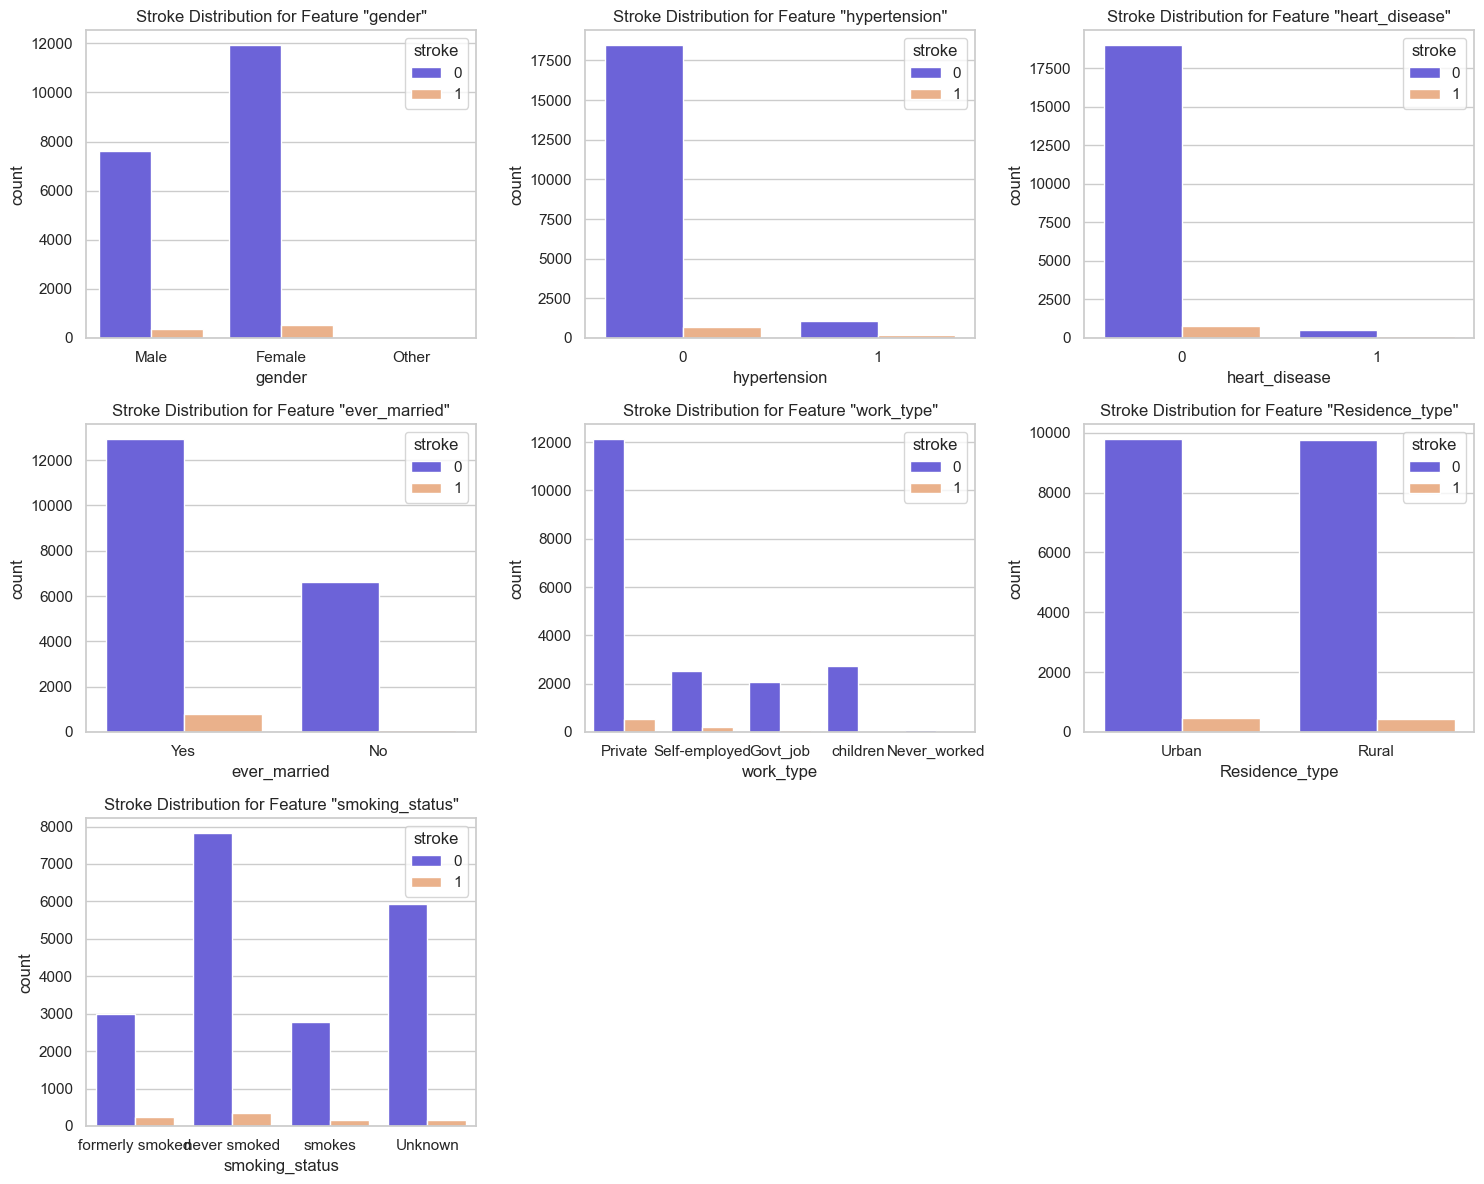

In [37]:
# Numerical features - histogram

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

numerical_features = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 8))

# Plot histograms for numerical features with different colors for stroke=0 and stroke=1
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[df['stroke'] == 0][feature], bins=30, kde=True, color='blue', label='Stroke = 0')
    sns.histplot(df[df['stroke'] == 1][feature], bins=30, kde=True, color='orange', label='Stroke = 1')
    plt.title(f'Stroke Distribution for Feature "{feature}"')
    plt.legend()

plt.tight_layout()
plt.show()


# Categorical features - bar chart

sns.set(style="whitegrid")

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

plt.figure(figsize=(15, 12))

# Plot count plots for categorical features with different colors for stroke=0 and stroke=1
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, data=df, hue='stroke', palette=['#5B4FEC',"#FAAE7B"])
    plt.title(f'Stroke Distribution for Feature "{feature}"')

plt.tight_layout()
plt.show()

### Visualizing distribution of features given the patient had stroke=1

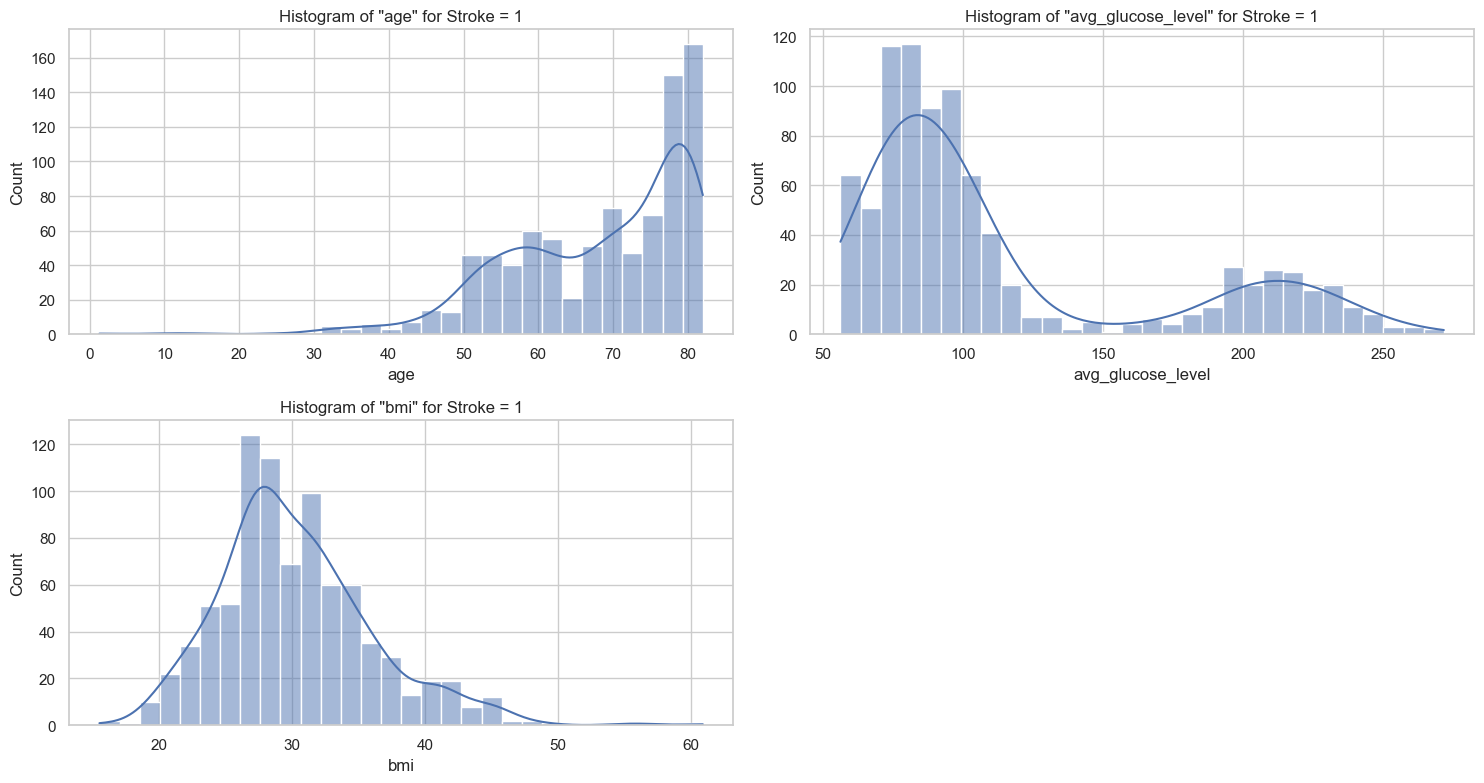

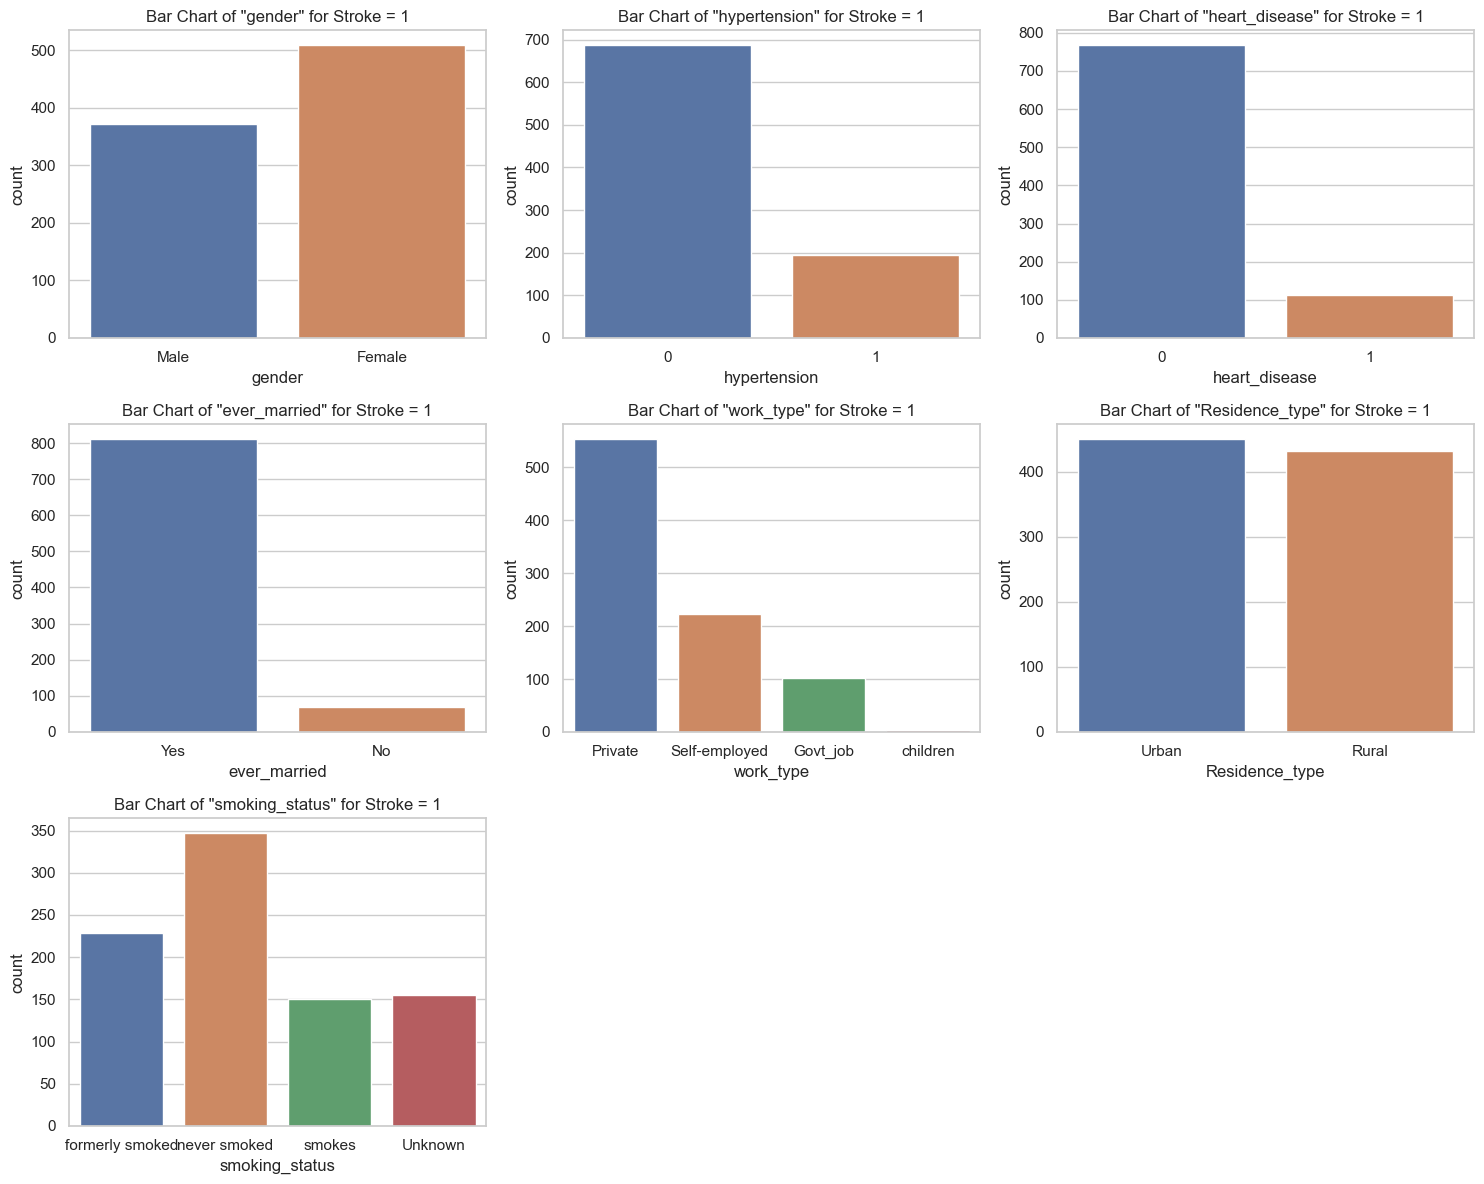

In [38]:
# Numerical features - histogram 

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[df['stroke'] == 1][feature], bins=30, kde=True)
    plt.title(f'Histogram of "{feature}" for Stroke = 1')

plt.tight_layout()
plt.show()

# Categorical features - bar chart
plt.figure(figsize=(15, 12))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, data=df[df['stroke'] == 1])
    plt.title(f'Bar Chart of "{feature}" for Stroke = 1')
    
plt.tight_layout()
plt.show()

## 2. Pre-processing the data

### Dropping rows with missing data

In [118]:
print("Dataset before processing:")
print("-" * 25)
print(f"Shape: {df.shape}\n")

print(df.astype('object').describe(include='all').loc['unique', :])
print()
print()

print("Dataset after processing:")
print("-" * 25)

df = df[df.smoking_status != "Unknown"]
print(f"Shape after filtering out 'Unknown' values from smoking_status: {df.shape}")

df = df.dropna()
print(f"Shape after dropping NA values: {df.shape}\n")

print(df.astype('object').describe(include='all').loc['unique', :])

Dataset before processing:
-------------------------
Shape: (20414, 12)

id                    19309
gender                    3
age                   106.0
hypertension              2
heart_disease             2
ever_married              2
work_type                 5
Residence_type            2
avg_glucose_level    4644.0
bmi                   440.0
smoking_status            4
stroke                    2
Name: unique, dtype: object


Dataset after processing:
-------------------------
Shape after filtering out 'Unknown' values from smoking_status: (14327, 12)
Shape after dropping NA values: (14187, 12)

id                    13712
gender                    3
age                    82.0
hypertension              2
heart_disease             2
ever_married              2
work_type                 5
Residence_type            2
avg_glucose_level    4053.0
bmi                   406.0
smoking_status            3
stroke                    2
Name: unique, dtype: object


### Standardizing numerical data

In [119]:
from sklearn.preprocessing import StandardScaler

num_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
num_cols = num_cols.delete([0, 2, 3, 6])
print(f"numerical data to standardize: {num_cols}\n")

scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])
print(df.head())

numerical data to standardize: Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')

      id  gender       age  ...       bmi   smoking_status stroke
0   9046    Male  1.091476  ...  1.080068  formerly smoked      1
2  31112    Male  1.816131  ...  0.443161     never smoked      1
3  60182  Female  0.088109  ...  0.738313           smokes      1
4   1665  Female  1.760388  ... -0.877257     never smoked      1
5  56669    Male  1.871874  ... -0.100541  formerly smoked      1

[5 rows x 12 columns]


### One-hot encoding categorical features

In [120]:
df = pd.get_dummies(df, columns=['gender', 'work_type', 'Residence_type', 'smoking_status'],  dtype=int)
df.replace({"Yes": 1, "No": 0}, inplace=True)

print(df.head())

      id       age  ...  smoking_status_never smoked  smoking_status_smokes
0   9046  1.091476  ...                            0                      0
2  31112  1.816131  ...                            1                      0
3  60182  0.088109  ...                            0                      1
4   1665  1.760388  ...                            1                      0
5  56669  1.871874  ...                            0                      0

[5 rows x 21 columns]


## 3. Dataset correlation exploration

### Feature correlation heatmap

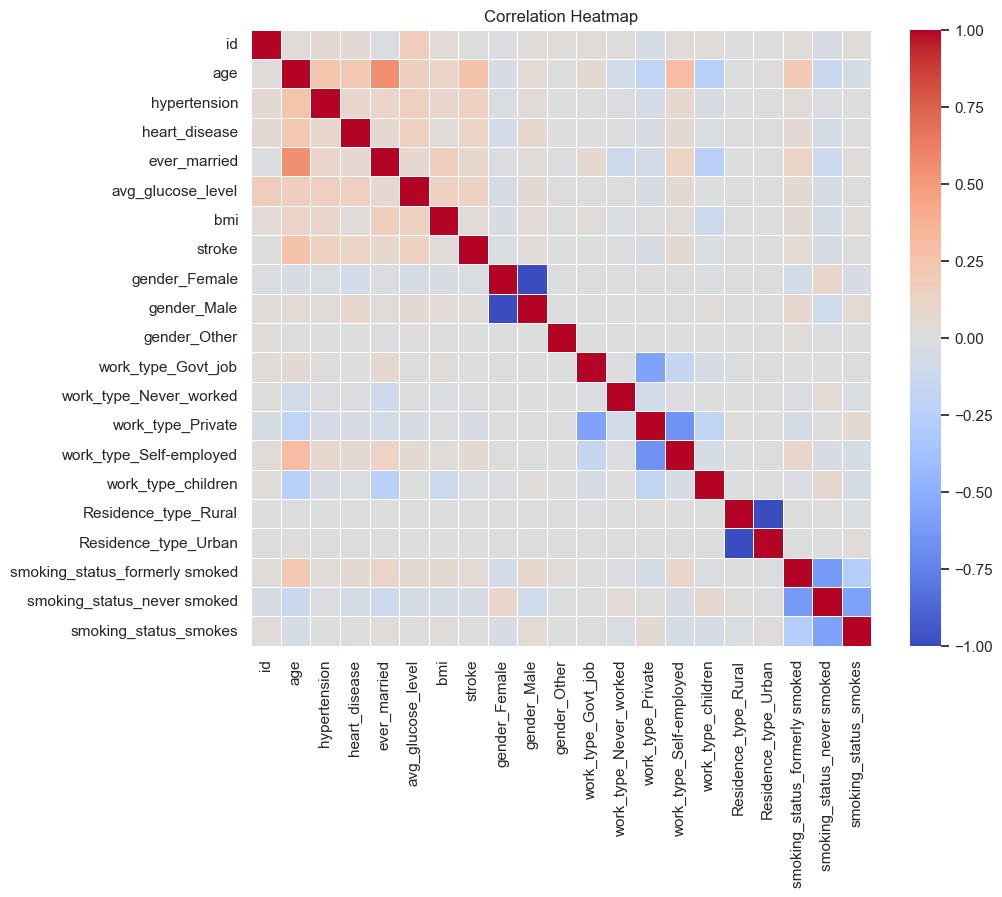

In [42]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Feature correlation with stroke likelihood

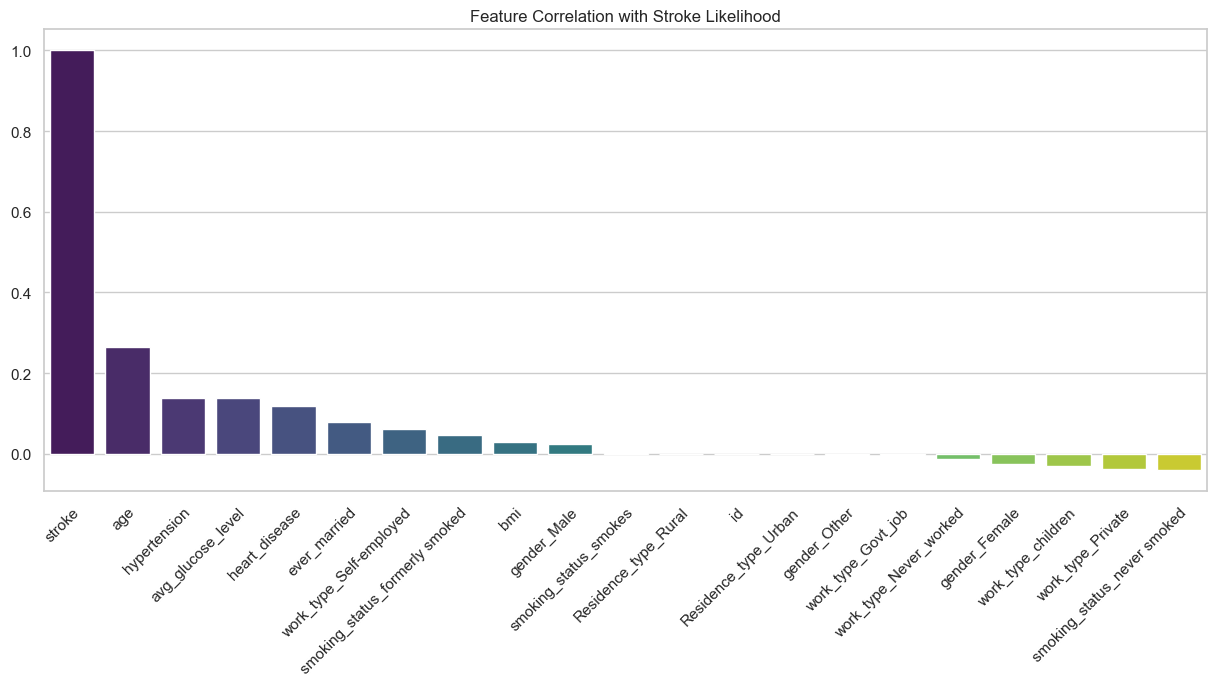

In [43]:
correlation_with_target = correlation_matrix['stroke'].sort_values(ascending=False)

plt.figure(figsize=(15, 6))

sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Feature Correlation with Stroke Likelihood')
plt.show()

### Plotting the distribution of stroke = 0 and stroke = 1.
There's a heavy class imbalance in the dataset favoring the majority class, stroke = 0.

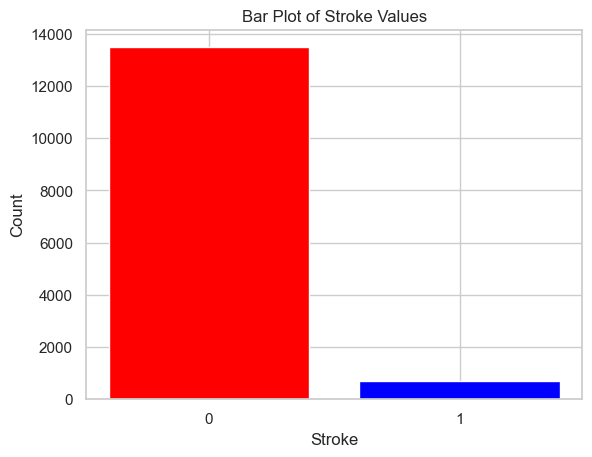

In [44]:
stroke_counts = df['stroke'].value_counts()

# Create a bar plot
plt.bar(stroke_counts.index, stroke_counts.values, color=['red', 'blue'])

# Add labels and title
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.title('Bar Plot of Stroke Values')

# Show the plot
plt.show()

## 4. Train-test-weight split + synthetic sampling for class imbalance mitigation

In [121]:
from sklearn.model_selection  import train_test_split
from sklearn.utils import class_weight
import time

weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=df['stroke'])

w = [weights[0] if stroke == 0 else weights[1] for stroke in df['stroke']]
y = df.pop('stroke')
X = df.to_numpy()

11349 2838 11349 2838 11349 2838


In [124]:
def train_test_weight_data():
    seed = np.random.seed(int(time.time()))
    return train_test_split(X, y, w, test_size=0.2, random_state=seed)

X_tr, X_te, y_tr, y_te, w_tr, w_te = train_test_weight_data()
print(len(X_tr), len(X_te), len(y_tr), len(y_te), len(w_tr), len(w_te))

11349 2838 11349 2838 11349 2838


### Generating synthetically sampled data for training using SMOTE in order to mitigate the negative effect originating from the strong class imbalance.
Ref: https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688


In [46]:
from imblearn.over_sampling import SMOTE

def smote_sample(X_tr, y_tr):
    sm = SMOTE(random_state=seed)

    # Synethetic sampling - balancing the minority class with the majority class by generating extra synthetic samples for training
    X_res, y_res = sm.fit_resample(X_tr, y_tr)
    return X_res, y_res

X_res, y_res = smote_sample(X_tr, y_tr)
print(f"SMOTE synethetically sampled data - X.shape: {X_res.shape}, y.shape: {y_res.shape}")

SMOTE synethetically sampled data - X.shape: (21546, 20), y.shape: (21546,)


## 5. Model Exploration

### Defining model evaluation metrics & functions

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, auc, precision_recall_curve

def weight_accuracy(predicted_y, true_y, weight):
    sum_weighted_correct_predictions = 0
    for yhat, y, w in zip(predicted_y, true_y, weight):
        if yhat == y:
            sum_weighted_correct_predictions += (1 * w)

    total_weight = sum(weight)
    return sum_weighted_correct_predictions / total_weight


def eval_model(predicted_y, true_y, weight):
    # Calculate precision, recall, and f1 score (useful for problems w/ class imbalances)
    precision = precision_score(true_y, predicted_y, sample_weight=weight)
    recall = recall_score(true_y, predicted_y, sample_weight=weight)
    f1 = f1_score(true_y, predicted_y, sample_weight=weight)
    weighted_accuracy = weight_accuracy(true_y, predicted_y, weight)

    # Print metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Weighted accuracy:", weighted_accuracy)

    print("-" * 20)
    
    # Print classification report and confusion matrix
    print("Classification Report:\n", classification_report(true_y, predicted_y, sample_weight=weight))
    print("\nConfusion Matrix:\n", confusion_matrix(true_y, predicted_y, sample_weight=weight))

    # Graph PR-curve
    p, r, _ = precision_recall_curve(true_y, predicted_y, sample_weight=weight)
    pr_auc = auc(r, p)
    plt.figure(figsize=(8, 8))
    plt.plot(r, p, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

### Defining grid-search helper functions for hyperparmeter-tuning

In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin


def do_grid_search(classifier: ClassifierMixin, param_grid: dict) -> GridSearchCV:
    """
    Perform a GridSearchCV using the provided classifier model and parameter grid.
    """
    X_tr, _, y_tr, _, _, _ = train_test_weight_data()
    X_res, y_res = smote_sample(X_tr, y_tr)

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=5, n_jobs=4)
    grid_search.fit(X_res, y_res)

    return grid_search


def evaluate_best_grid_search_result(grid_search: GridSearchCV) -> None:
    """
    Evaluate the best model found by the GridSearchCV.
    """
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    print()

    _, X_te, _, y_te, _, w_te = train_test_weight_data()

    best_model = grid_search.best_estimator_
    y_pred_te = best_model.predict(X_te)

    eval_model(y_pred_te, y_te, w_te)
    

def plot_gridsearch_2d_hyperparameter_accuracy_heatmap(grid_search: GridSearchCV, param1_name: str, param2_name: str) -> None:
    """
    Plot a 2D heatmap showing the GridSearchCV's accuracy across the two hyperparameters' searched values.
    """
    df = pd.DataFrame(grid_search.cv_results_)

    heatmap_data = df.pivot_table(index=f"param_{param1_name}", columns=f"param_{param2_name}", values='mean_test_score')

    # Create heatmap of the mean test scores given certain hyperparameter configurations
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='vlag', fmt='.4f', cbar_kws={'label': 'Accuracy Score'})
    plt.title('Grid Search Results')
    plt.xlabel(param2_name)
    plt.ylabel(param1_name)
    plt.yticks(rotation=0)
    plt.show()


def do_grid_search_full_task(classifier: ClassifierMixin, param_grid: dict, param1_name: str=None, param2_name: str=None) -> GridSearchCV:
    """
    Performs grid search, evaluates the best model, and plots the heatmap of the two given params.
    returns: GridSearchCV
    """
    grid_search = do_grid_search(classifier, param_grid)
    print("\n" + "-" * 20)
    
    evaluate_best_grid_search_result(grid_search)

    if param1_name and param2_name:
        plot_gridsearch_2d_hyperparameter_accuracy_heatmap(grid_search, param1_name, param2_name)

    return grid_search

### A. Logistic Regression

In [234]:
from sklearn.linear_model import LogisticRegression

def do_logistic_regression(X_tr, y_tr, X_te, y_te, w_te):
    logistic_regression_model = LogisticRegression()

    # Train the model
    logistic_regression_model.fit(X_tr, y_tr)
    y_pred_te = logistic_regression_model.predict(X_te)

    # Training weighted accuracy
    y_pred_tr = logistic_regression_model.predict(X_tr)
    print(f"Training accuracy: {weight_accuracy(y_pred_tr, y_tr, w_tr)}")

    # Validation weighted accuracy
    y_pred_te = logistic_regression_model.predict(X_te)
    print(f"Validation accuracy: {weight_accuracy(y_pred_te, y_te, w_te)}")

    print(f"Score: {logistic_regression_model.score(X_te, y_te, sample_weight=w_te)}\n")
    eval_model(y_pred_te, y_te, w_te)

#### An example of poor accuracy and results (will happen to all models) due to the majority/minority class imbalance issue

Training accuracy: 0.49994043178752157
Validation accuracy: 0.49968221936418866
Score: 0.4996822193641703

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Weighted accuracy: 0.49968221936418866
--------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67 1418.9104427798316
           1       0.00      0.00      0.00 1420.7151988636363

    accuracy                           0.50 2839.625641643468
   macro avg       0.25      0.50      0.33 2839.625641643468
weighted avg       0.25      0.50      0.33 2839.625641643468


Confusion Matrix:
 [[1418.91044278    0.        ]
 [1420.71519886    0.        ]]


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

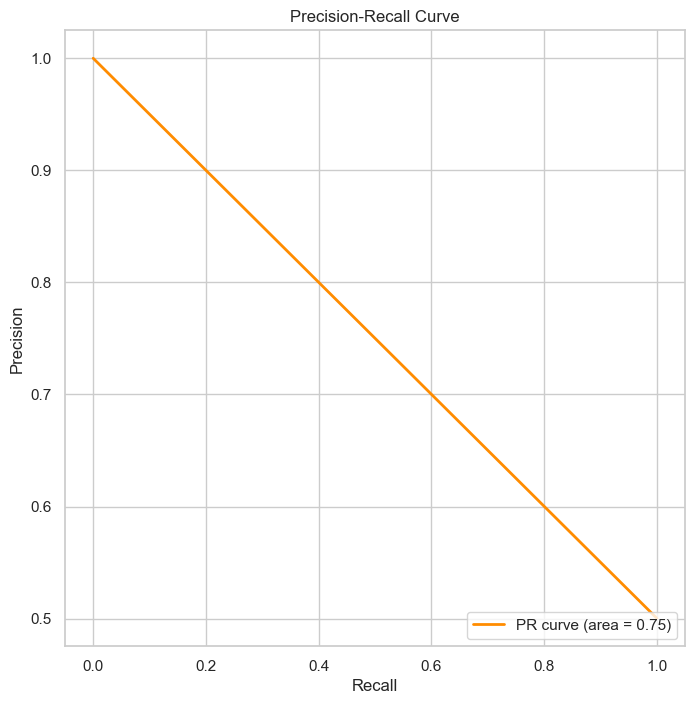

In [125]:
X_tr, X_te, y_tr, y_te, w_tr, w_te = train_test_weight_data()
do_logistic_regression(X_tr, y_tr, X_te, y_te, w_te)

#### Improved: Mitigating the class imbalance issue using SMOTE - generates synthetic samples to balance the minority class and majority class data.
Improved precision, recall, and weighted accuracy.

Training accuracy: 0.7655678345614635
Validation accuracy: 0.7583161810741977
Score: 0.7583161810741695

Precision: 0.7657998296076893
Recall: 0.7446808510638313
F1 Score: 0.7550927014879275
Weighted accuracy: 0.7583161810741977
--------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76 1418.9104427798316
           1       0.77      0.74      0.76 1420.7151988636363

    accuracy                           0.76 2839.625641643468
   macro avg       0.76      0.76      0.76 2839.625641643468
weighted avg       0.76      0.76      0.76 2839.625641643468


Confusion Matrix:
 [[1095.35466884  323.55577394]
 [ 362.73579545 1057.97940341]]


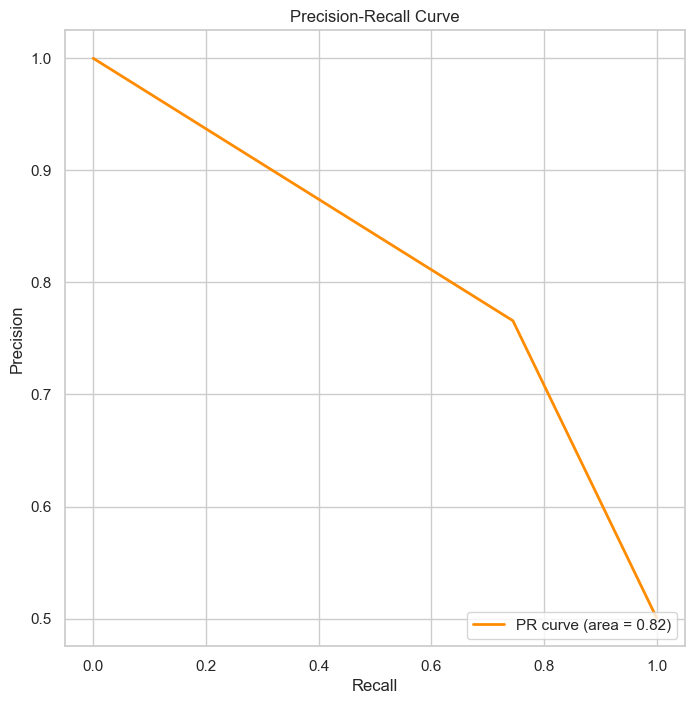

In [127]:
# Fitting the model using the synthetic samples
X_res, y_res = smote_sample(X_tr, y_tr)

do_logistic_regression(X_res, y_res, X_te, y_te, w_te)

#### Grid-searching for the best hyperparameters

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarni

[CV 3/5] END C=100, penalty=l2, solver=newton-cg;, score=0.800 total time=   2.4s
[CV 1/5] END C=100, penalty=l2, solver=newton-cg;, score=0.789 total time=   2.5s
[CV 2/5] END C=100, penalty=l2, solver=newton-cg;, score=0.792 total time=   2.6s
[CV 2/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, penalty=l2, solver=newton-cg;, score=0.795 total time=   2.6s
[CV 1/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.1s
[CV 3/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.1s
[CV 5/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 4/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.768 total time=   0.1s
[CV 1/5] END C=100, penalty=l2, solver=liblinear;, score=0.789 total time=   0.0s
[CV 2/5] END C=100, penalty=l2, solver=liblinear;, score=0.791 total time=   0.1s
[CV 3/5] END C=100, penalty=l2, solver=liblinear;, score=0.800 total time=   0.1s
[CV 4/5] END C=100, penalty=l2, solver=liblinear;, score=0.795 total time=   0.0s
[CV 5/5] END C=100, penalty=l2, solver=liblinear;, score=0.803 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarni

[CV 5/5] END C=100, penalty=l2, solver=newton-cg;, score=0.804 total time=   1.9s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=10, penalty=l2, solver=newton-cg;, score=0.789 total time=   2.2s
[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=0.800 total time=   2.1s
[CV 1/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.778 total time=   0.1s
[CV 2/5] END C=10, penalty=l2, solver=newton-cg;, score=0.792 total time=   2.3s
[CV 2/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 3/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.1s
[CV 4/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.768 total time=   0.1s
[CV 5/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.789 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.800 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.795 total time=   0.0s
[CV 5/5] END C=10, penalty=l

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarni

[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=0.795 total time=   2.4s
[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=0.804 total time=   1.8s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorith

[CV 2/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.792 total time=   1.9s
[CV 1/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.789 total time=   2.1s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

[CV 1/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.787 total time=   0.3s
[CV 2/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 3/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.1s
[CV 4/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.768 total time=   0.1s
[CV 5/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.789 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.800 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.795 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.803 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.800 total time=   2.2s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.795 total time=   2.6s
[CV 5/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.804 total time=   2.2s
[CV 1/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.789 total time=   1.5s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarni

[CV 2/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.792 total time=   1.4s
[CV 1/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.778 total time=   0.1s
[CV 2/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.804 total time=   0.8s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarni

[CV 3/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.1s
[CV 5/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.795 total time=   1.1s
[CV 3/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.800 total time=   1.3s
[CV 4/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.1s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.789 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.792 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.801 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.795 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.803 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/opti

[CV 2/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.790 total time=   0.8s
[CV 1/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.787 total time=   1.0s
[CV 4/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.796 total time=   1.0s
[CV 2/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.798 total time=   1.1s
[CV 3/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.777 total time=   0.1s
[CV 5/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.500 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.789 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.790 total time=   0.0s
[CV 4/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.787 total time=   0.2s
[CV 1/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.789 total time=   0.4s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.800 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.797 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.804 total time=   0.0s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

[CV 5/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.803 total time=   0.9s


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



--------------------
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

Precision: 0.789652779776867
Recall: 0.7612903225806464
F1 Score: 0.7752122157534324
Weighted accuracy: 0.7680951829204657
--------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76 1411.544945486943
           1       0.79      0.76      0.78 1561.7791193181808

    accuracy                           0.77 2973.324064805124
   macro avg       0.77      0.77      0.77 2973.324064805124
weighted avg       0.77      0.77      0.77 2973.324064805124


Confusion Matrix:
 [[1094.82856189  316.71638359]
 [ 372.81178977 1188.96732955]]


/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


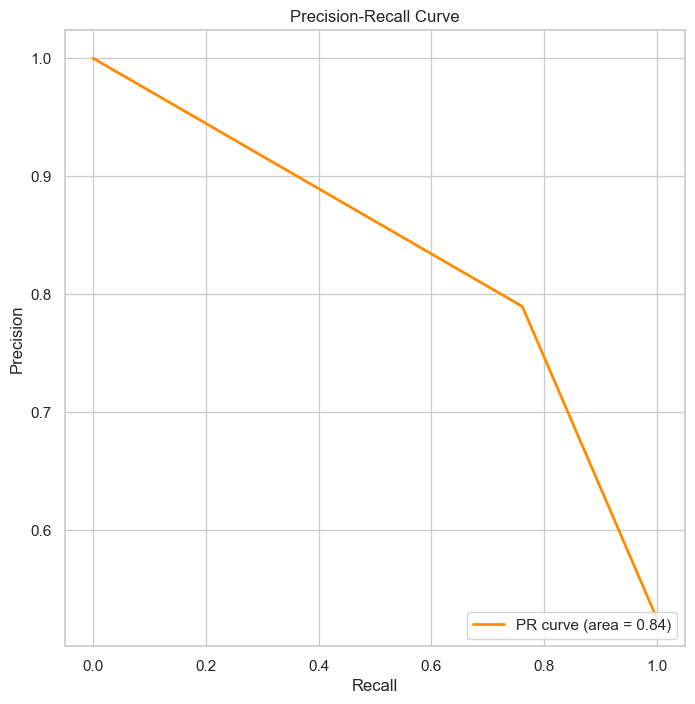

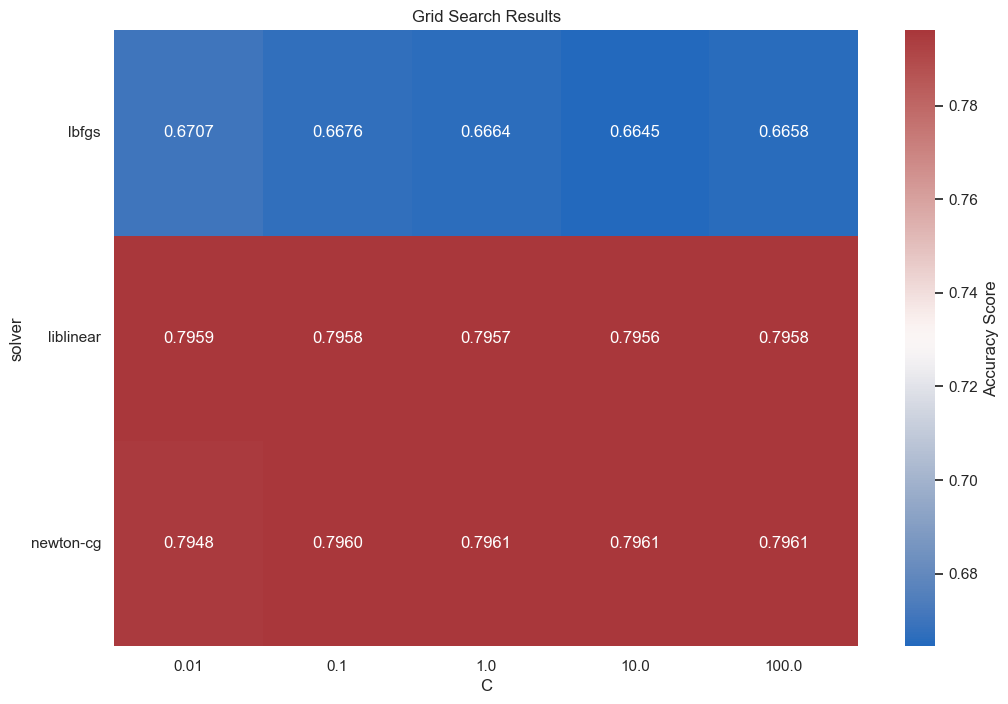

In [254]:
log_reg_model = LogisticRegression()
log_reg_param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}
log_reg_grid_search = do_grid_search_full_task(log_reg_model, log_reg_param_grid, 'solver', 'C')

In [255]:
import joblib

joblib.dump(log_reg_grid_search, 'log_reg_grid_search_object.joblib')

['log_reg_grid_search_object.joblib']

<hr style="border:2px solid gray">

### B. Decision Tree Classifier

#### Grid-searching for best parameters

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.875 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.967 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.961 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.963 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END max_depth=None, max_features

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 2/5] END max_depth=None, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END max_depth=None, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.885 total time=

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 5/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 1/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.843 total time=   0.0s
[CV 3/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 5/5] END max_depth=None, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.845 total t

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.840 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.853 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=auto, max_leaf_nodes=30, min_impurity_decrease=0.0;, score=0.878 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.854 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.877 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.949 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=auto, max_leaf_nodes=30, min_impurity_decrease=0.0;, score=0.909 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.874 total time=   0.0s
[CV 

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.1;, score=0.788 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.937 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.1;, score=0.791 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.773 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 5/5] END max_depth=20, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=20, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.868 total time=   0.0s
[CV 2/5] END max_depth=20, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 3/5] END max_depth=20, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 1/5] END max_depth=20, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.785 total time=   0.0s
[CV 5/5] END max_depth=20, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.894 total time=   0.0s
[CV 4/5] END max_depth=20, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.1;, score=0.791 total time=   0.0s
[CV 4/5] END max_depth=20, max_features=auto, max_leaf_nodes=30, min_impurity_decrease=0.0;, score=0.915 total time=   0.0s
[CV 1/

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.791 total time=   0.0s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.866 total time=   0.0s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 2/5] END max_depth=30, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.818 total time=   0.0s
[CV 3/5] END max_depth=30, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.967 total time=   0.0s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=30, min_impurity_decrease=0.0;, score=0.920 total time=   0.0s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=30, min_impurity_decrease=0.1;, score=0.772 total time=   0.0s
[CV 3/5] END max_depth=30, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.0;, score=0.863 total time=   0.0s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=30, min_impurity_decrease=0.1;, score=0.788 total time=   0.0s
[CV 4/5] END max_depth=30, max_features=auto, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=30, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0;, score=0.959 total time=   0.0s
[CV 

/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/brianlin/anaconda3/envs/184a_stroke_prediction/lib/python3.8/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_feature

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.875 total time=   0.0s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.772 total time=   0.0s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.1;, score=0.500 total time=   0.0s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.2;, score=0.500 total time=   0.0s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=20, min_impurity_decrease=0.0;, score=0.906 total time=   0.0s
[CV 

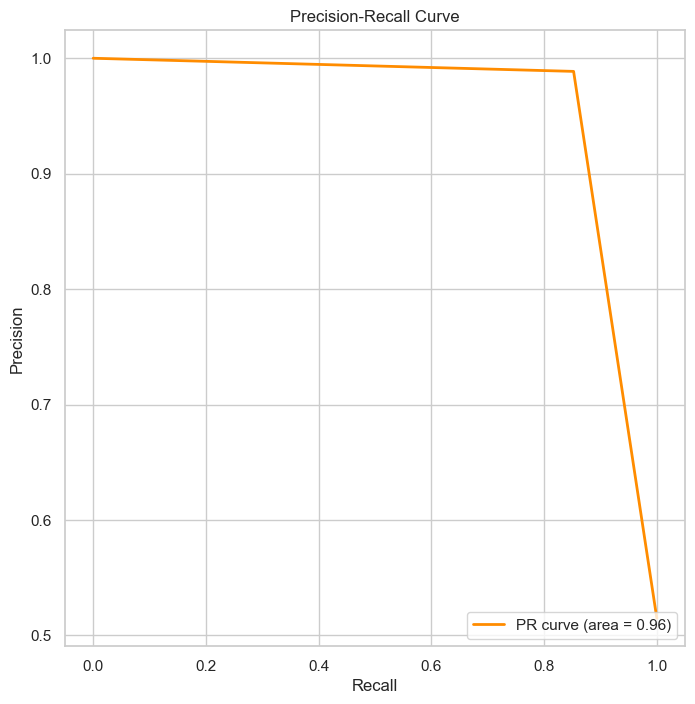

In [256]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}
dt_grid_search = do_grid_search_full_task(dt_model, dt_param_grid)

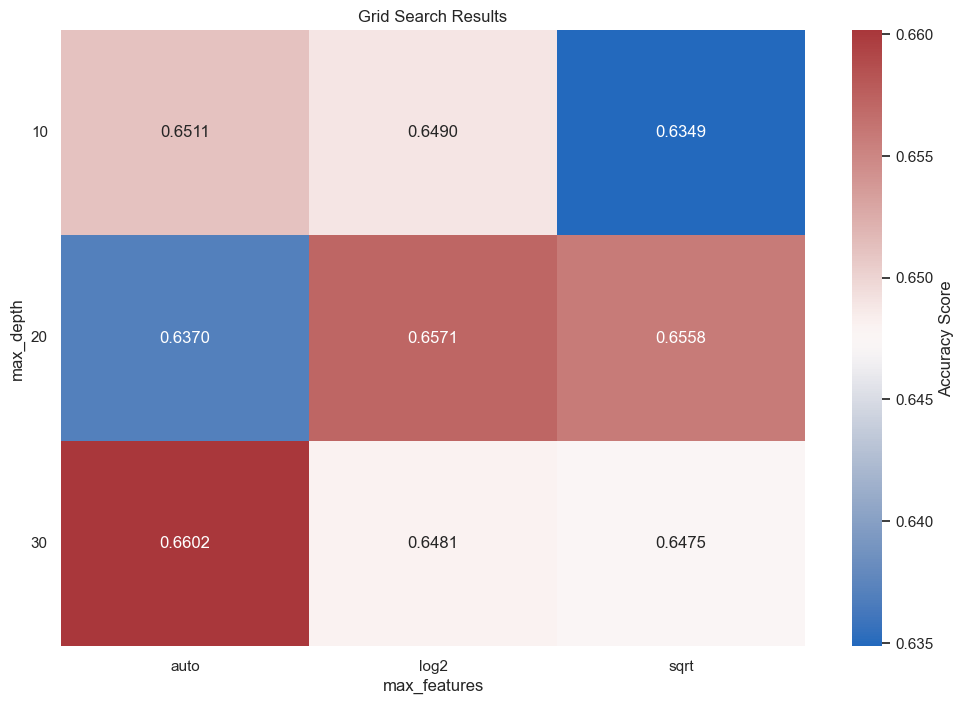

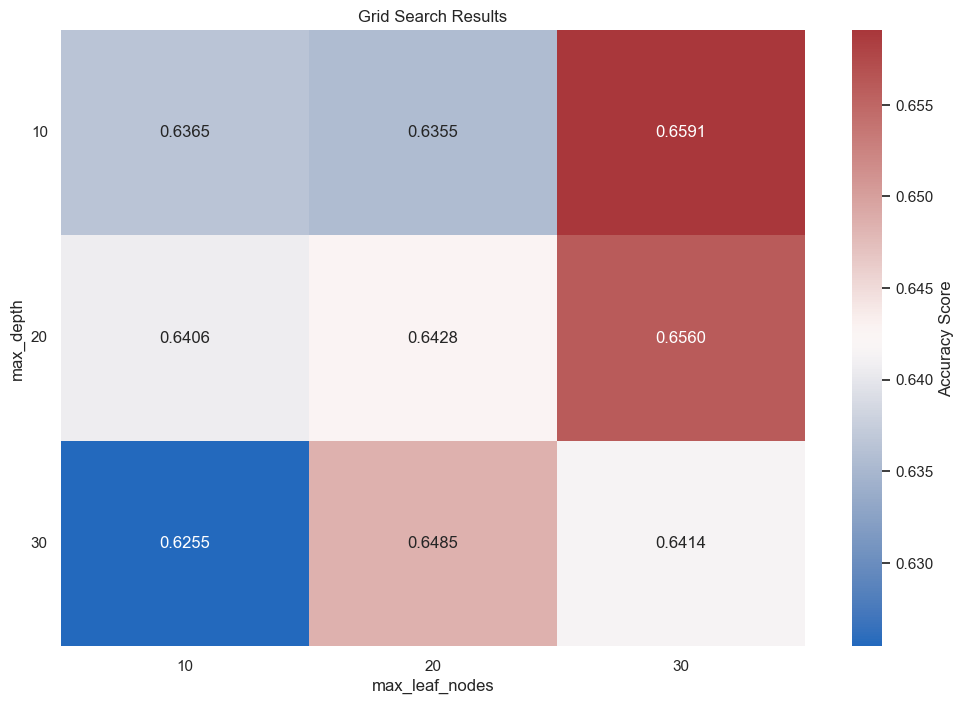

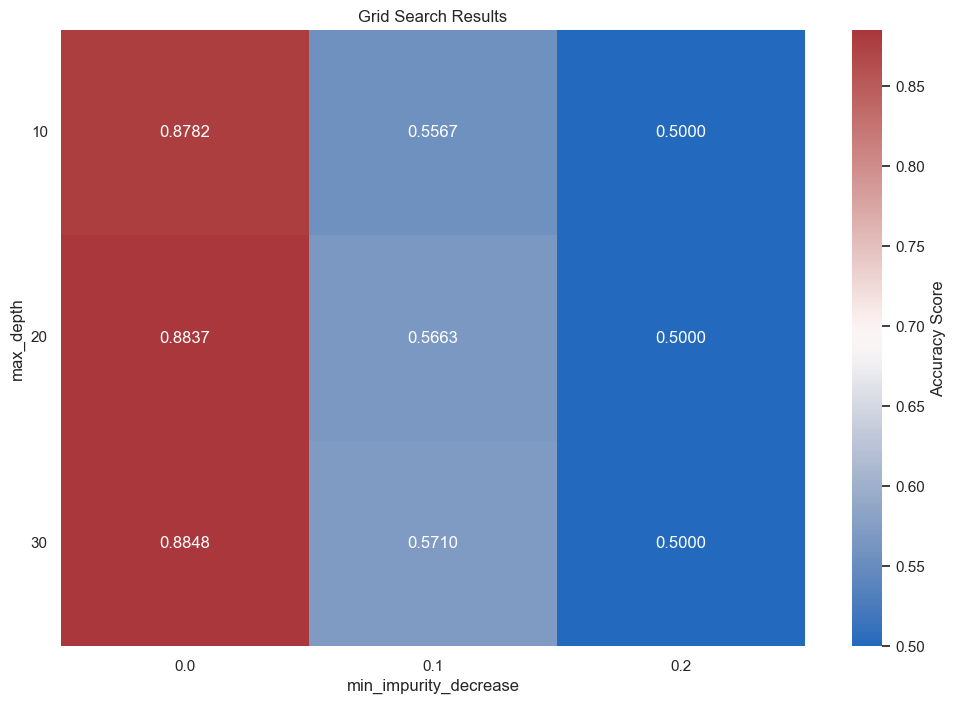

In [259]:
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(dt_grid_search, "max_depth", "max_features")
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(dt_grid_search, "max_depth", "max_leaf_nodes")
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(dt_grid_search, "max_depth", "min_impurity_decrease")

In [261]:
import joblib

joblib.dump(dt_grid_search, 'dt_grid_search_object.joblib')

['dt_grid_search_object.joblib']

<hr style="border:2px solid gray">

### C. Random Forest Classifier

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV 1/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.871 total time=   1.5s
[CV 3/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.994 total time=   1.5s
[CV 4/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.995 total time=   1.6s
[CV 2/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.997 total time=   1.6s
[CV 5/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.993 total time=   1.6s
[CV 1/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.872 total time=   2.9s
[CV 3/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.995 tot

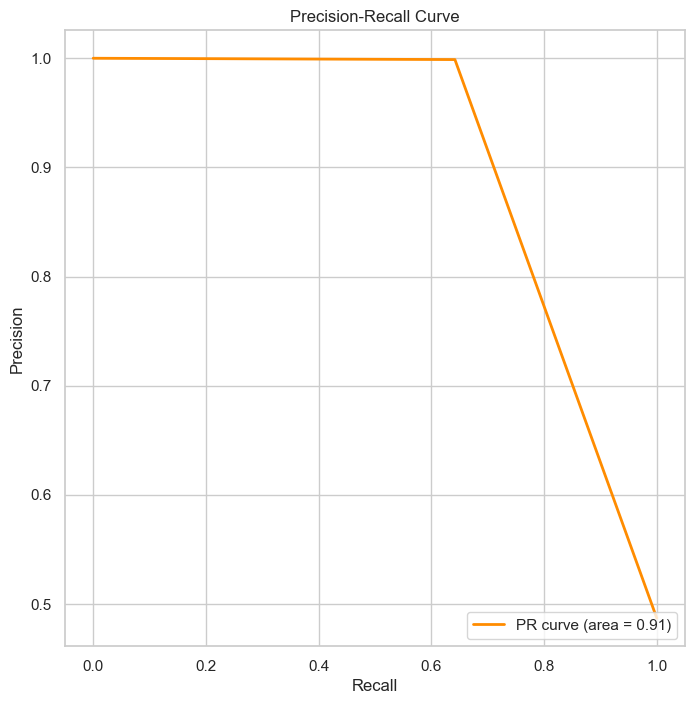

In [260]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [None, 2, 4, 8, 16, 32, 64, 128],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_grid_search = do_grid_search_full_task(rf_model, rf_param_grid)

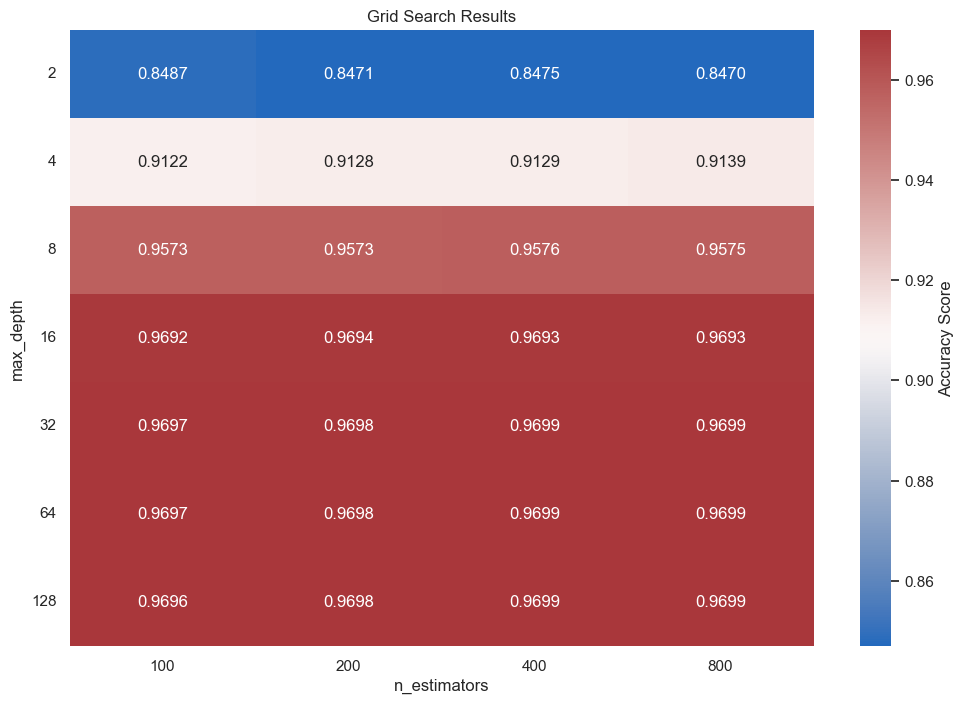

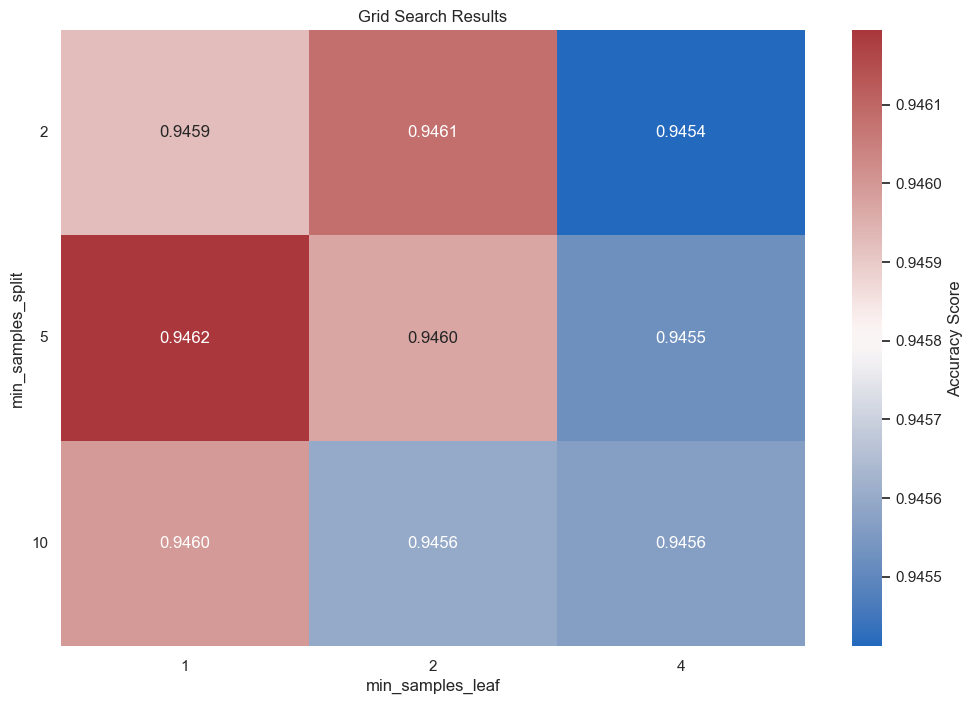

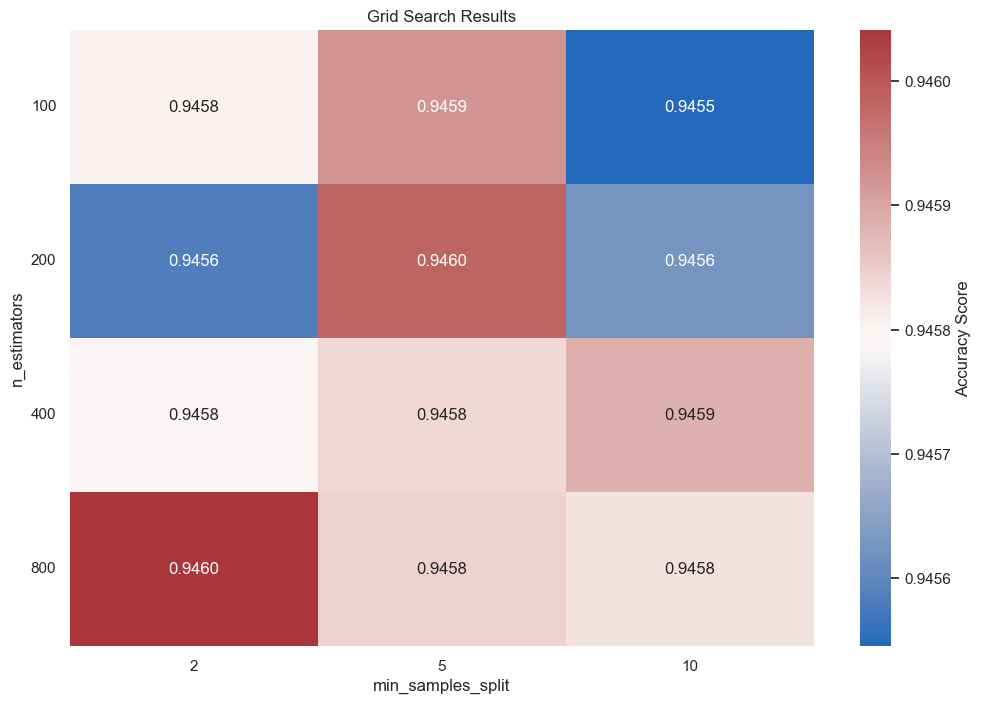

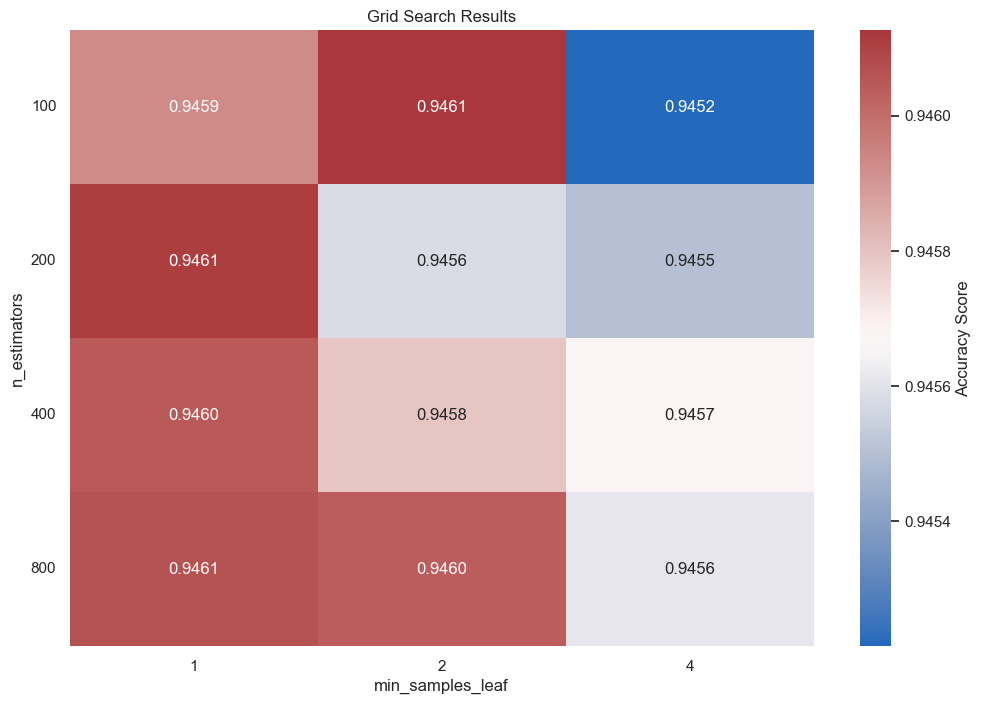

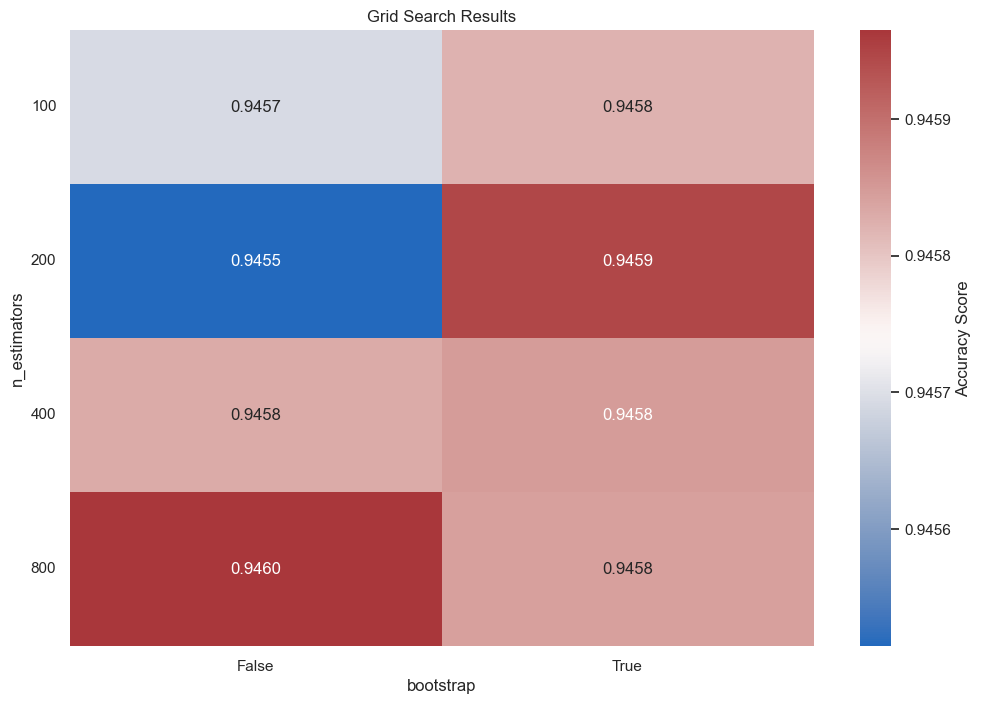

In [267]:
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(rf_grid_search, "max_depth", 'n_estimators')
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(rf_grid_search, "min_samples_split", 'min_samples_leaf')
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(rf_grid_search, "n_estimators", 'min_samples_split')
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(rf_grid_search, "n_estimators", 'min_samples_leaf')
plot_gridsearch_2d_hyperparameter_accuracy_heatmap(rf_grid_search, "n_estimators", 'bootstrap')

In [263]:
import joblib

joblib.dump(rf_grid_search, 'rf_grid_search_object.joblib')

['rf_grid_search_object.joblib']

<hr style="border:2px solid gray">